In [1]:
import pandas as pd

# Dokumentácia

## Motivácia

Našou témou bude veľmi častá úloha v oblasti NLP (Natural language processing), konkrétne analýza sentimentu. Na začiatok by sme chceli natrénovať modely na binárnu klasifikáciu používateľských recenzií k filmom. Keďže klasifikácia recenzií je pomerne jednoduchá úloha, poskytuje nám široké možnosti experimentovania a priestor na pridanie rôznych rozšírení k zadaniu.

Analýza sentimentu (známa aj ako prieskum názorov, opinion mining) je oblasťou aktívneho výskumu v oblasti spracovania prirodzeného jazyka. Zameriava sa na identifikáciu, získavanie a organizovanie sentimentov z textov generovaných používateľmi v sociálnych sieťach, blogoch alebo recenziách produktov vie nám povedať, čo si ľudia myslia o danom produkte. Práve kvôli tomu má široké využitie hlavne pre firmy, ktoré sa snažia prispôsobiť svôj produkt pre zákazníkov alebo sa sústreďujú na user experiance.

Analyzovať tisíce recenzií manuálne je časovo aj finančne náročné. Na pomoc prichádza AI a jeho podoblasť NLP, ktorá sa už viacero rokov zaoberá analýzou sentimentu. Oproti iným metódam, neurónové siete majú tú vyhodu, že sa dokážu pomerne jednoducho prispôsobiť danej doméne. Nerobia im problémy ani skratky alebo slang. Navyše sa nám téma javí ako zaujímavá z dôvodu nášho záujmu o filmy, práca na tejto téme je pre nás o to zábavnejšia.

## Podobné práce

Veľmi jednoduchým riešením je použitie rekurentných sietí, ktoré sú na túto úlohu ako stvorené.

-	Graves, Alex. "Supervised sequence labelling with recurrent neural networks. 2012." URL https://www.cs.toronto.edu/~graves/preprint.pdf (2012).

Existuje však mnoho rozšírení, ktoré je možné aplikovať aj v našej práci napr. mechanizmy pozornosti alebo konvolučné siete.

-	Olah, Chris, and Shan Carter. "Attention and augmented recurrent neural networks." Distill 1.9 (2016): e1.
-	Zhang, Xiang, Junbo Zhao, and Yann LeCun. "Character-level convolutional networks for text classification." Advances in neural information processing systems. 2015.
-	Zhang, Lei, Shuai Wang, and Bing Liu. "Deep learning for sentiment analysis: A survey." Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery 8.4 (2018): e1253.
-	Tang, Duyu, Bing Qin, and Ting Liu. "Deep learning for sentiment analysis: successful approaches and future challenges." Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery 5.6 (2015): 292-303.

## Dataset

In [2]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

test_df.drop(columns=['Unnamed: 0'], inplace = True)
train_df.drop(columns=['Unnamed: 0'], inplace = True)

Náš dataset sa skladá z dvoch časti - trénovacej sady a testovacej sady. Obe sady majú 25 000 záznamov, pričom polovica je vždy označená ako negatívne a druhá polovica ako pozitívne.

### Náhľad dát

In [3]:
test_df.head()

,review_text,sentiment
0,A strange relationship between a middle-aged w...,pos
1,Yesterday was one of those days we decided to ...,neg
2,"This movie was rented for free, I had no misco...",neg
3,This is one of Chaplin's First National films ...,pos
4,"I enjoyed Ramin Bahrani's Man Push Cart, and t...",pos


In [4]:
train_df.head()

,review_text,sentiment
0,I really enjoyed watching this movie about the...,pos
1,i saw this film by accident and this movie was...,neg
2,To bad for this fine film that it had to be re...,pos
3,"A clever, undeniably entertaining romp starrin...",pos
4,"I recently rented this doc, having remembered ...",pos


Dáta sa skladajú z dvoch atribútov - review text a sentiment. Prvý atribút **review_text** obsahuje celú textovú recenziu, druhý atribút **sentiment** označuje či je recenzia pozitívna (pos), alebo negatívna (neg).

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review_text    25000 non-null object
sentiment      25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review_text    25000 non-null object
sentiment      25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


In [7]:
test_df.describe()

,review_text,sentiment
count,25000,25000
unique,24801,2
top,Loved today's show!!! It was a variety and not...,pos
freq,5,12500


In [8]:
train_df.describe()

,review_text,sentiment
count,25000,25000
unique,24904,2
top,"When i got this movie free from my job, along ...",pos
freq,3,12500


### Počet pozitívnych a negatívnych recenzií v dátach

In [9]:
test_df['sentiment'].value_counts()

pos    12500
neg    12500
Name: sentiment, dtype: int64

In [10]:
train_df['sentiment'].value_counts()

pos    12500
neg    12500
Name: sentiment, dtype: int64

### Prekrývajúce sa dáta

In [11]:
overlap = train_df.isin(test_df)
overlap[overlap['review_text'] == True]

,review_text,sentiment


Zistili sme, že v našich dátach sa nenachádzajú žiadne riadky, ktoré by boli aj v trénovacích dátach aj v testovacích.

### Tokenizácia

In [12]:
import tensorflow as tf

In [13]:
def get_tokenizer(vocab_file, vocab_size, separator='\n'):
    vocab = open(vocab_file).read()
    tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, split=separator, oov_token=1)
    tokenizer.fit_on_texts([vocab])
    return tokenizer

tokenizer = get_tokenizer('dataset/aclImdb/imdb.vocab', 10001)

### Metriky pre recenzie

In [20]:
test_df['review_text'].str.len().describe()

count    25000.00000
mean      1293.79240
std        975.90776
min         32.00000
25%        696.00000
50%        962.00000
75%       1572.00000
max      12988.00000
Name: review_text, dtype: float64

In [21]:
train_df['review_text'].str.len().describe()

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: review_text, dtype: float64

In [22]:
lengths = pd.DataFrame(train_df['review_text'].str.len())
lengths.rename(columns={"review_text": "review_len"}, inplace=True)

lengths.boxplot(column=['review_len'])

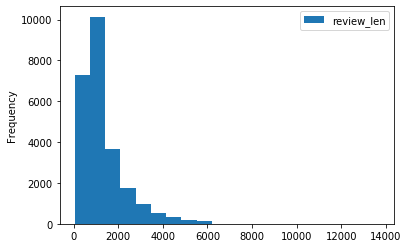

In [23]:
lines = lengths.plot.hist(bins=20)

### Histogram frekvencie slov

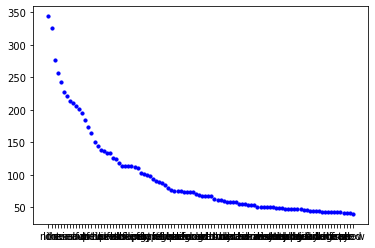

In [24]:
import json
data = json.loads(tokenizer.to_json())
data = json.loads(data["config"]["word_counts"])

words = [key for key, value in data.items()]
counts = [value for key, value in data.items()]

data = list(zip(words, counts))
data = sorted(data, key=lambda d: d[1], reverse=True)

words = [d[0] for d in data]
counts = [d[1] for d in data]

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.scatter(
    words[:100],
    counts[:100],
    color="blue",
    s=10
  )
plt.show()

## Architektúra

### Diagram BiLSTM

![BiLSTM](assets/bilstm-diag.png)

### Diagram self-attention

![BiLSTM](assets/attn-diag.png)

![BiLSTM](assets/xxx1-diag.png)

In [27]:
TODO: POPIS

NameError: name 'POPIS' is not defined

![BiLSTM](assets/xxx2-diag.png)

In [ ]:
TODO: POPIS

![BiLSTM](assets/xxx3-diag.png)

In [ ]:
TODO: popis

![BiLSTM](assets/xxx4-diag.png)

In [ ]:
TODO: POPIS

## Training routine

## Experimenty

Robili sme experiment, v ktorom sme sa snažili analyzovať sentiment používateľských recenzií. Použili sme škálu modelov s rôznymi konfiguráciami vrstiev, napríklad BiLSTM, LSTM s mechanizmami pozornosti pred a po LSTM vrstve, hierarchické LSTM siete s a bez BiLSTM a mechanizmom pozornosti.

Z experimentov vyplýva, že ak sme sa spoliehali len na jednosmerné LSTM tak niekedy bol problém s modelom, že nevedel zovšeobecňovať (toto bolo v prípade aj klasických LSTM aj hierarchických LSTM).

Všetky siete mali rovnaký výkon a dosahovali presnosť 0.85 maximálne, nezávisle od modelu alebo počtu neurónov v ich vrstvách. Sústredili sme sa potom na zistenie toho, ktorý model sa vie natrénovať najrýchlejšie. Najviac sme boli spokojný s BiLSTM s Attentionnom. Najrýchlejšie sa trénoval a nemal problém konvergovať k niečomu užitočnému od začiatku. Najhoršie na tom boli hierarchické neurónové siete s jednosmernou LSTM sieťou. Pravdepodobne kvôli tomu, že nevedeli vytvoriť zmysluplnú reprezentáciu viet.

### Výsledky